# Exercise 0 (CNN Version)

Train a three-layers MLP to solve the MNIST classification problem
* Each MNIST image is 1x28x28, reshape it to 768
* The MLP should have 300 hidden neurons
* The MLP should have 10 output neurons, one per each class
* Use the LeakyReLU activation function
* Use the CrossEntropyLoss loss function


In [1]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

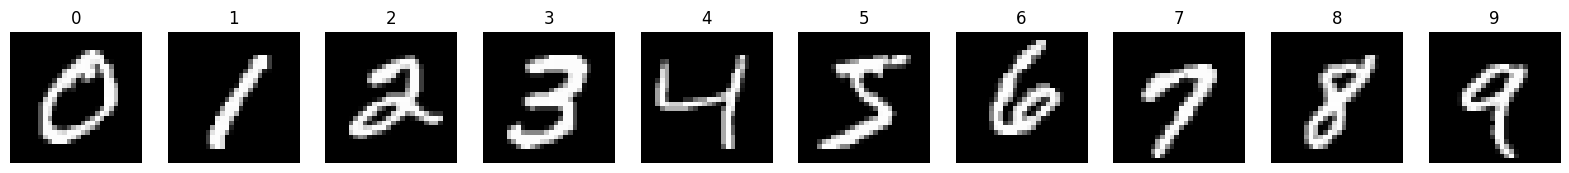

torch.Size([1, 28, 28])

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

for i in range(10):
    for digit, cls in train_mnist:
        if cls == i:
            digit = digit.numpy().squeeze()
            axes[i].imshow(digit, cmap='gray')
            axes[i].set_title(str(i))
            axes[i].axis('off')
            break
plt.show()
train_mnist[0][0].shape # 1 x 28 x 28

In [23]:
class Classifier(torch.nn.Module):
    
    def __init__(self, n_classes=10):
        super().__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, (3, 3)),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, (3, 3)),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten()
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(18432, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 10),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        cnn = self.cnn(x)
        return self.fc(cnn)

## Train the Model

In [25]:
model = Classifier()
model = model.to(DEVICE)

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = []

for epoch in range(3):
    bar = tqdm(dl)
    for i, (digit, cls) in enumerate(bar):
        digit = digit.to(DEVICE)
        cls = cls.to(DEVICE)

        pred = model(digit)
        
        loss = loss_fn(pred, cls)
        accuracy = (pred.argmax(dim=1) == cls).float().mean()
        bar.set_description(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            loss_history.append(loss.item())

plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()

Loss: 1.4924, Accuracy: 0.9688: 100%|██████████| 1875/1875 [02:33<00:00, 12.25it/s]


## Test the Model

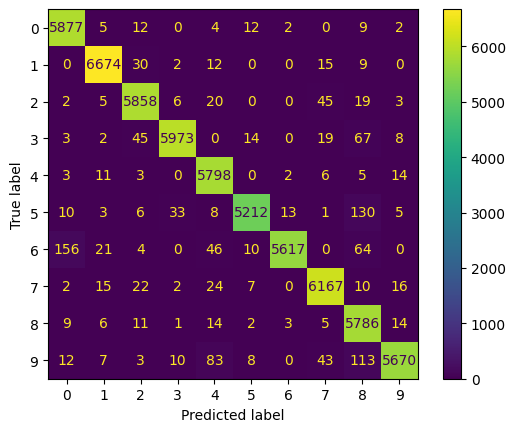

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)

true_labels = torch.tensor([], dtype=torch.int)
pred_labels = torch.tensor([], dtype=torch.int)

for digit, cls in dl:
    digit = digit.to(DEVICE)
    cls = cls.to(DEVICE)

    pred = model(digit)
    
    true_labels = torch.cat((true_labels, cls))
    pred_labels = torch.cat((pred_labels, pred.argmax(dim=1)))

cm = confusion_matrix(true_labels.detach().numpy(), pred_labels.detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()